In [83]:
import pandas as pd
from matplotlib import pyplot as plt

from exercise20_botStrom import create_fulfillment_process
import numpy as np
import simpy
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
net, im, fm = create_fulfillment_process()

In [58]:
net

places: [ p_packed, p_picked, p_received, p_validated, sink, source ]
transitions: [ (Pack, 'Pack'), (Pick, 'Pick'), (Receive, 'Receive'), (Ship, 'Ship'), (Validate, 'Validate') ]
arcs: [ (Pack, 'Pack')->p_packed, (Pick, 'Pick')->p_picked, (Receive, 'Receive')->p_received, (Ship, 'Ship')->sink, (Validate, 'Validate')->p_validated, p_packed->(Ship, 'Ship'), p_picked->(Pack, 'Pack'), p_received->(Validate, 'Validate'), p_validated->(Pick, 'Pick'), source->(Receive, 'Receive') ]

# Simulation code

In [64]:
def package_process(env, name, validate, pick, pack, ship, idx):
    time_points.append(env.now)
    id.append(idx)
    activity.append('Receive')
    yield env.timeout(np.random.normal(ACTIVITY_DURATIONS['Receive']['mean'], ACTIVITY_DURATIONS['Receive']['std']))


    with validate.request() as req:
        yield req
        time_points.append(env.now)
        id.append(idx)
        activity.append('Validate')
        #len(res.queue)
        yield env.timeout(np.random.normal(ACTIVITY_DURATIONS['Validate']['mean'], ACTIVITY_DURATIONS['Validate']['std']))

    with pick.request() as req:
        yield req
        time_points.append(env.now)
        id.append(idx)
        activity.append('Pick')
        yield env.timeout(np.random.normal(ACTIVITY_DURATIONS['Pick']['mean'], ACTIVITY_DURATIONS['Pick']['std']))

    with pack.request() as req:
        yield req
        time_points.append(env.now)
        id.append(idx)
        activity.append('Pack')
        yield env.timeout(np.random.normal(ACTIVITY_DURATIONS['Pack']['mean'], ACTIVITY_DURATIONS['Pack']['std']))

    with ship.request() as req:
        yield req
        time_points.append(env.now)
        id.append(idx)
        activity.append('Ship')
        yield env.timeout(np.random.normal(ACTIVITY_DURATIONS['Ship']['mean'], ACTIVITY_DURATIONS['Ship']['std']))


In [86]:
ACTIVITY_DURATIONS = {
    'Receive': {'mean': 2, 'std': 0.5},      # Automatic, fast
    'Validate': {'mean': 5, 'std': 1.0},     # Manual validation
    'Pick': {'mean': 8, 'std': 1.5},         # Walking + picking items
    'Pack': {'mean': 6, 'std': 1.0},         # Packing boxes
    'Ship': {'mean': 3, 'std': 0.5}          # Label + handoff
}

# Resource pools
RESOURCES = {
    'Validate': 3,  # 3 validators
    'Pick': 5,      # 5 pickers
    'Pack': 5,      # 2 packers (BOTTLENECK)
    'Ship': 2       # 2 shippers
}

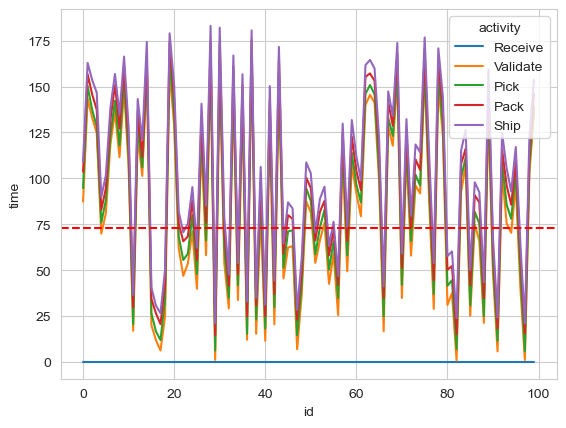

In [87]:
initial_packages = 100
time_points = []
id = []
packages = []
activity = []

env = simpy.Environment()

validate = simpy.Resource(env, capacity=RESOURCES['Validate'])
pick = simpy.Resource(env, capacity=RESOURCES['Pack'])
pack = simpy.Resource(env, capacity=RESOURCES['Pack'])
ship = simpy.Resource(env, capacity=RESOURCES['Ship'])

for i in range(initial_packages):
    env.process(package_process(env, f"Package {i+1}", validate, pick, pack, ship, i))
env.run()

result_log = pd.DataFrame({'time': time_points, 'id': id, 'activity': activity})

fig, ax = plt.subplots()
sns.lineplot(data=result_log, x='id', y='time', hue='activity', ax=ax)
ax.axhline(result_log['time'].mean(), ls="--", color='red', label='Average Time')